Install hehe

In [128]:
#pip install matplotlib

In [129]:
#pip install seaborn

In [130]:
#pip install pandas

In [131]:
#pip install pywaffle

In [132]:
#pip install joypy

In [133]:
#pip install statsmodels

In [134]:
#pip install scikit-learn

In [135]:
#pip install yellowbrick

imports

In [136]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from pywaffle import  Waffle
import joypy
import gc
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot
from sklearn.preprocessing import StandardScaler
from yellowbrick.regressor import CooksDistance
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import joblib

In [137]:
df_price = pd.read_csv('data/resale_price.csv')
df_price = df_price.dropna().reset_index(drop=True)
df_price = df_price.drop_duplicates(ignore_index=True)
df_price['month'] = pd.to_datetime(df_price['month'], format='%Y-%m')
print('df_price shape :', df_price.shape)
df_price.head(3)

df_price shape : (155653, 11)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0


In [138]:
df_price['flat_type'] = df_price['flat_type'].str.replace('MULTI-GENERATION', 'MULTI GENERATION')
df_price['flat_type'].unique()

array(['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
       'MULTI GENERATION'], dtype=object)

In [139]:
replace_values = {'NEW GENERATION':'New Generation', 'SIMPLIFIED':'Simplified', 'STANDARD':'Standard', 'MODEL A-MAISONETTE':'Maisonette', 'MULTI GENERATION':'Multi Generation', 'IMPROVED-MAISONETTE':'Executive Maisonette', 'Improved-Maisonette':'Executive Maisonette', 'Premium Maisonette':'Executive Maisonette', '2-ROOM':'2-room', 'MODEL A':'Model A', 'MAISONETTE':'Maisonette', 'Model A-Maisonette':'Maisonette', 'IMPROVED':'Improved', 'TERRACE':'Terrace', 'PREMIUM APARTMENT':'Premium Apartment', 'Premium Apartment Loft':'Premium Apartment', 'APARTMENT':'Apartment', 'Type S1':'Type S1S2', 'Type S2':'Type S1S2'}
df_price = df_price.replace({'flat_model': replace_values})
df_price['flat_model'].value_counts()

flat_model
Model A                 52824
Improved                38648
New Generation          19541
Premium Apartment       17915
Simplified               6062
Apartment                5976
Maisonette               4819
Standard                 4357
DBSS                     2757
Model A2                 1788
Type S1S2                 429
Adjoined flat             278
Terrace                    90
Multi Generation           72
2-room                     49
Executive Maisonette       36
3Gen                       12
Name: count, dtype: int64

In [140]:
df_price['storey_range'].unique()

array(['10 TO 12', '01 TO 03', '04 TO 06', '07 TO 09', '13 TO 15',
       '19 TO 21', '22 TO 24', '16 TO 18', '34 TO 36', '28 TO 30',
       '37 TO 39', '49 TO 51', '25 TO 27', '40 TO 42', '31 TO 33',
       '46 TO 48', '43 TO 45'], dtype=object)

In [141]:
df_price['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

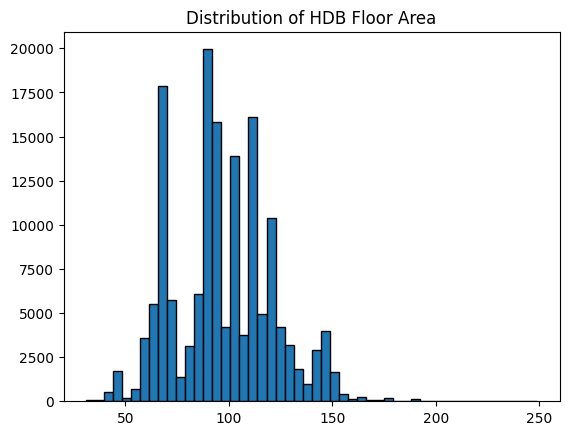

flat_model
Terrace                 6
Executive Maisonette    2
Maisonette              2
Name: count, dtype: int64

In [142]:
plt.hist(df_price['floor_area_sqm'], bins=50, edgecolor='black')
plt.title('Distribution of HDB Floor Area')
plt.show()
display(df_price[df_price['floor_area_sqm'] > 200]['flat_model'].value_counts())

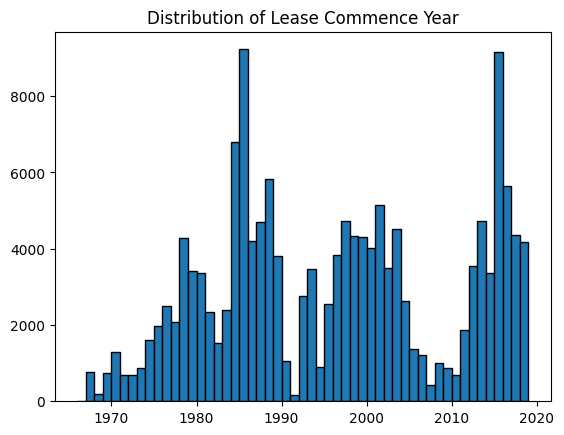

In [143]:
bins = df_price['lease_commence_date'].max() - df_price['lease_commence_date'].min()
plt.hist(df_price['lease_commence_date'], bins=bins, edgecolor='black')
plt.title('Distribution of Lease Commence Year')
plt.show()

In [144]:
cpi = pd.read_csv('data/cpi_singapore.csv')

In [145]:
cpi['month'] = pd.to_datetime(cpi['month'], format='%Y %b') # to datetime
df_price = df_price.merge(cpi, on='month', how='left')
df_price['real_price'] = (df_price['resale_price'] / df_price['cpi']) * 100

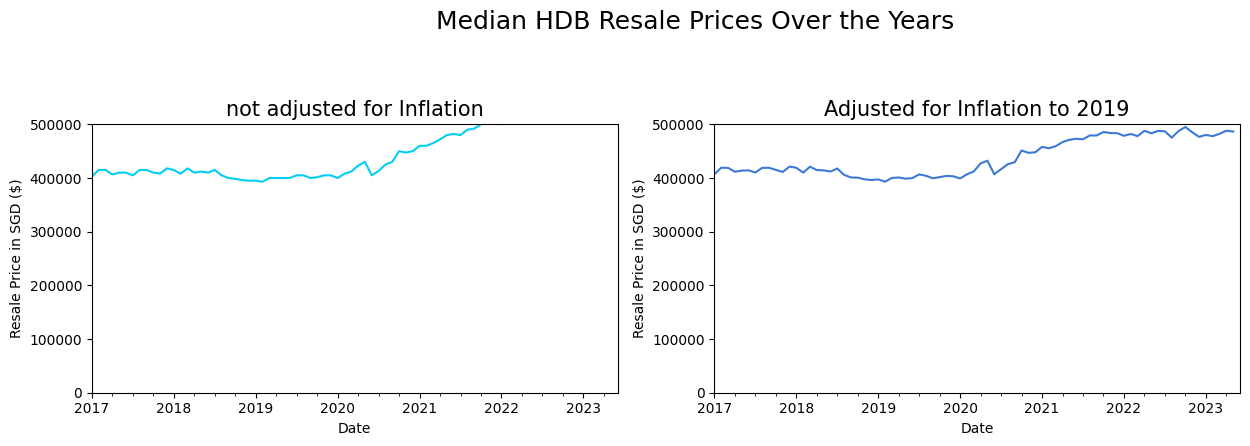

In [146]:
fig = plt.figure(figsize=(14,4.5))
fig.suptitle('Median HDB Resale Prices Over the Years', fontsize=18)
plt1 = fig.add_subplot(121)
df_price.groupby('month')[['resale_price']].median().plot(ax=plt1, color='#00cef6', legend=None)
plt1.set_xlabel('Date'), plt1.set_ylabel('Resale Price in SGD ($)'), plt1.set_ylim(0, 500000), plt1.set_title('not adjusted for Inflation', size=15)

plt2 = fig.add_subplot(122)
df_price.groupby('month')[['real_price']].median().plot(ax=plt2, color='#3c78d8', legend=None)
plt2.set_xlabel('Date'), plt2.set_ylabel('Resale Price in SGD ($)'), plt2.set_ylim(0, 500000), plt2.set_title('Adjusted for Inflation to 2019',size=15)

plt.tight_layout(rect=[0, 0, 0.9, 0.9]) 
plt.show()

In [147]:
# Convert remaining_lease to number of years
def getYears(text):
    if isinstance(text, str):
        yearmonth = [int(s) for s in text.split() if s.isdigit()]
        if len(yearmonth) > 1: # if there's year and month
            years = yearmonth[0] + (yearmonth[1]/12)
        else: # if only year
            years = yearmonth[0]
        return years
    else: # if int
        return text

df_price['remaining_lease'] = df_price['remaining_lease'].apply(lambda x: getYears(x))

In [148]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155653 entries, 0 to 155652
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                155653 non-null  datetime64[ns]
 1   town                 155653 non-null  object        
 2   flat_type            155653 non-null  object        
 3   block                155653 non-null  object        
 4   street_name          155653 non-null  object        
 5   storey_range         155653 non-null  object        
 6   floor_area_sqm       155653 non-null  float64       
 7   flat_model           155653 non-null  object        
 8   lease_commence_date  155653 non-null  int64         
 9   remaining_lease      155653 non-null  float64       
 10  resale_price         155653 non-null  float64       
 11  cpi                  154228 non-null  float64       
 12  real_price           154228 non-null  float64       
dtypes: datetime64[

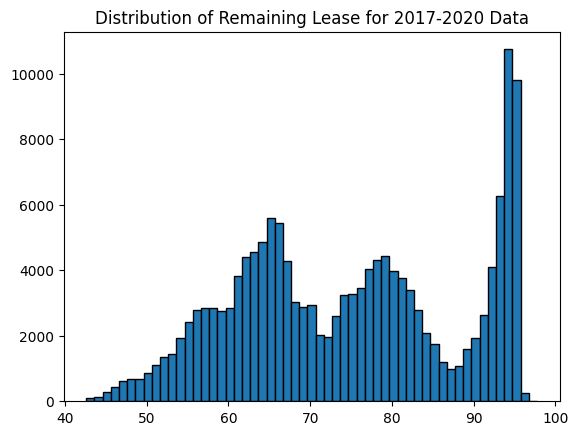

In [149]:
bins = df_price['remaining_lease'].max() - df_price['remaining_lease'].min()
plt.hist(df_price['remaining_lease'], bins=int(bins), edgecolor='black')
plt.title('Distribution of Remaining Lease for 2017-2020 Data')
plt.show()

In [150]:
df_price.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,cpi,real_price
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.333333,232000.0,99.026,234281.905762
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.583333,250000.0,99.026,252458.950175
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.416667,262000.0,99.026,264576.979783
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62.083333,265000.0,99.026,267606.487185
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.416667,265000.0,99.026,267606.487185


Explore By Flat Type

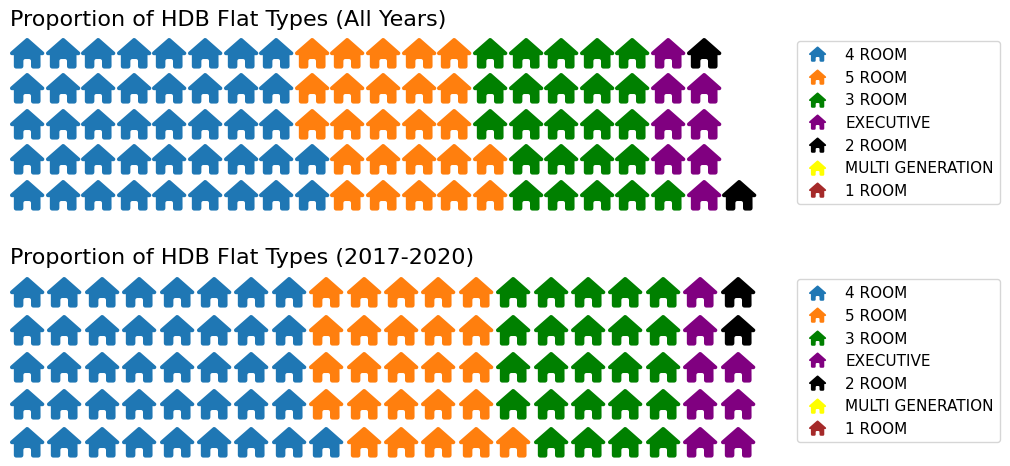

In [151]:
flattype = dict(df_price['flat_type'].value_counts()/len(df_price)*100)
flattype15to19 = dict(df_price.set_index('month')['2017':'2020'].reset_index()['flat_type'].value_counts()/len(df_price.set_index('month')['2017':'2020'].reset_index())*100)

plt.figure(figsize=(10,5),
    FigureClass=Waffle, 
    plots={
        211: {
            'values': flattype,
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize':11},
            'title': {'label': 'Proportion of HDB Flat Types (All Years)', 'loc': 'left', 'fontsize':16}
        },
        212: {
            'values': flattype15to19,
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize':11},
            'title': {'label': 'Proportion of HDB Flat Types (2017-2020)', 'loc': 'left', 'fontsize':16}            
        },
    },
    rows=5, 
    colors=["#1f77b4", "#ff7f0e", "green", 'purple', 'black', 'yellow', 'brown'],
    #colors=["#3c78d8", "#00cef6", "#aff000", '#28324a', 'black', 'yellow', 'brown'],
    icons='home', 
    font_size=22, 
    icon_legend=True)
    
plt.show()

In [152]:
flattype = ['3 ROOM','4 ROOM','5 ROOM','EXECUTIVE']
prices17to20 = df_price.set_index('month').sort_index().loc['2017-01':'2020-12']
prices17to20 = prices17to20[prices17to20['flat_type'].isin(flattype)][['flat_type','real_price']].reset_index()
prices17to20['flat_type_year'] = prices17to20['flat_type'] + ' - ' + prices17to20['month'].apply(lambda x: str(x)[:4])
prices17to20

,month,flat_type,real_price,flat_type_year
0,2017-01-01,4 ROOM,345363.843839,4 ROOM - 2017
1,2017-01-01,4 ROOM,338294.993234,4 ROOM - 2017
2,2017-01-01,4 ROOM,307999.919213,4 ROOM - 2017
3,2017-01-01,5 ROOM,868458.788601,5 ROOM - 2017
4,2017-01-01,5 ROOM,807868.640559,5 ROOM - 2017
...,...,...,...,...
85952,2020-12-01,5 ROOM,895798.704078,5 ROOM - 2020
85953,2020-12-01,5 ROOM,895798.704078,5 ROOM - 2020
85954,2020-12-01,5 ROOM,826125.471538,5 ROOM - 2020
85955,2020-12-01,5 ROOM,507619.265644,5 ROOM - 2020


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


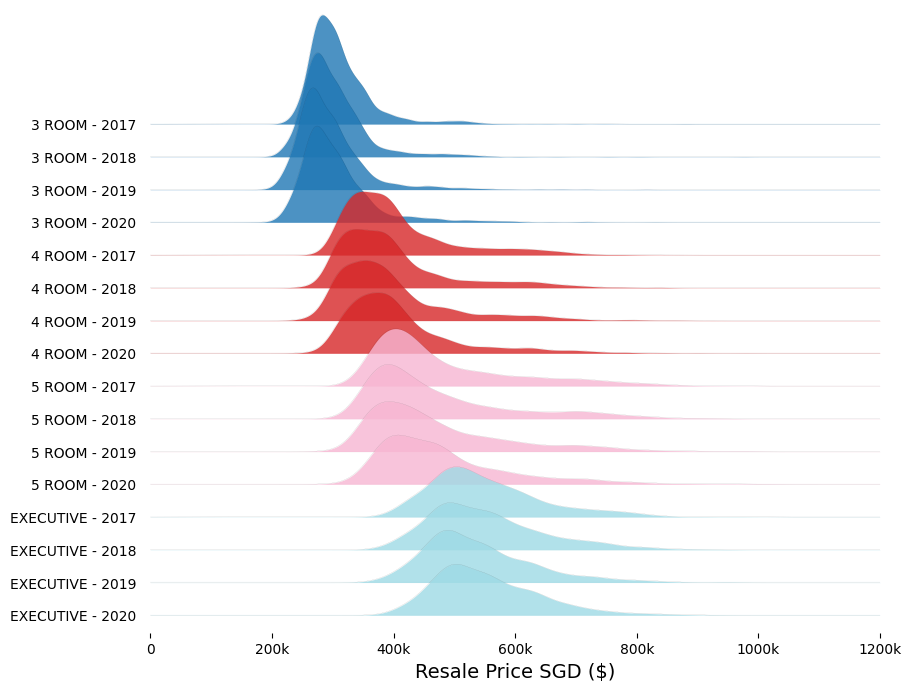

In [153]:
fig, axes = joypy.joyplot(prices17to20, by="flat_type_year", column="real_price",figsize=(9,7),
             linewidth=0.05,overlap=1.5,alpha=0.8,colormap=plt.cm.get_cmap('tab20',4))
axes[-1].set_xlim([0,1200000])
axes[-1].set_xticklabels(['0', '200k', '400k', '600k', '800k', '1000k', '1200k', '1400k']) 
plt.xlabel('Resale Price SGD ($)', fontsize=14)
fig.show()

Explore by Town

In [154]:
## 2017 to 2020
df_price['year'] = pd.DatetimeIndex(df_price['month']).year # extract out year
prices17to20 = df_price[df_price['year'].isin([2017,2018,2019,2020])].groupby(['town'], as_index=False).agg({'real_price': 'median'}).sort_values('real_price', ascending=True).reset_index(drop=True)
prices17to20['real_price'] = round(prices17to20['real_price']/1000)
prices17to20['color'] = ['#f8766d'] + ['#3c78d8']*(len(prices17to20)-2) + ['#00ba38']

# 4-room
prices17to20_4room = df_price[(df_price['flat_type'].isin(['4 ROOM'])) & (df_price['year'].isin([2017,2018,2019,2020]))].groupby(['town'], as_index=False).agg({'real_price': 'median'}).sort_values('real_price', ascending=True).reset_index(drop=True)
prices17to20_4room['real_price'] = round(prices17to20_4room['real_price']/1000)
prices17to20_4room['color'] = ['#f8766d','#f8766d'] + ['#3c78d8']*(len(prices17to20_4room)-3) + ['#00ba38']

In [155]:
# Function for lollipop charts
def loll_plot(df, x, y, subtitle, xlabel, xlim):
    plt.rc('axes', axisbelow=True)
    plt.grid(linestyle='--', alpha=0.4)
    plt.hlines(y=df.index, xmin=0, xmax=df[x], color=df.color, linewidth=1)
    plt.scatter(df[x], df.index, color=df.color, s=300)
    for i, txt in enumerate(df[x]):
        plt.annotate(str(round(txt)), (txt, i), color='white', fontsize=9, ha='center', va='center')
    plt.annotate(subtitle, xy=(1, 0), xycoords='axes fraction', fontsize=20,
                    xytext=(-5, 5), textcoords='offset points',
                    ha='right', va='bottom')
    plt.yticks(df.index, df[y]); plt.xticks(fontsize=12); plt.xlim(xlim)
    plt.xlabel(xlabel, fontsize=14)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


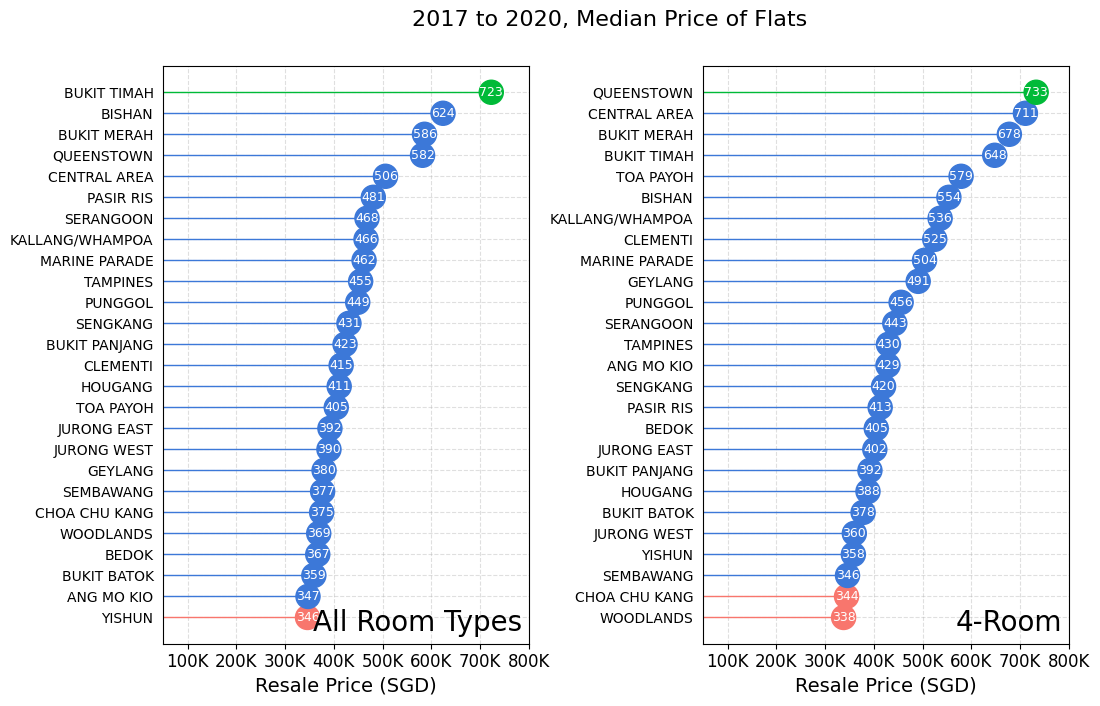

In [156]:
fig = plt.figure(figsize=(12,7))

plt1 = plt.subplot(121)
loll_plot(prices17to20, 'real_price', 'town', 'All Room Types', 'Resale Price (SGD)', [50,800])
plt1.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in plt1.get_xticks()])
plt1.yaxis.set_ticks_position('none') 

plt2 = plt.subplot(122)
loll_plot(prices17to20_4room, 'real_price', 'town', '4-Room', 'Resale Price (SGD)', [50,800])
plt2.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in plt2.get_xticks()])
plt2.yaxis.set_ticks_position('none') 

fig.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.suptitle('2017 to 2020, Median Price of Flats', fontsize=16)
plt.show()

In [157]:
df_price[df_price['year'].isin([2018,2019])].groupby('town')['lease_commence_date'].median().sort_values()

town
MARINE PARADE      1975.0
ANG MO KIO         1980.0
BEDOK              1980.0
CLEMENTI           1980.0
KALLANG/WHAMPOA    1982.0
GEYLANG            1982.0
TOA PAYOH          1984.0
JURONG EAST        1984.0
CENTRAL AREA       1984.0
SERANGOON          1986.0
BUKIT MERAH        1986.0
BUKIT BATOK        1986.0
YISHUN             1988.0
BUKIT TIMAH        1988.0
BISHAN             1988.0
TAMPINES           1988.0
HOUGANG            1989.0
PASIR RIS          1993.0
QUEENSTOWN         1995.0
CHOA CHU KANG      1996.0
JURONG WEST        1997.0
WOODLANDS          1997.0
BUKIT PANJANG      1999.0
SEMBAWANG          2001.0
SENGKANG           2006.0
PUNGGOL            2013.0
Name: lease_commence_date, dtype: float64

FixedFormatter should only be used together with FixedLocator


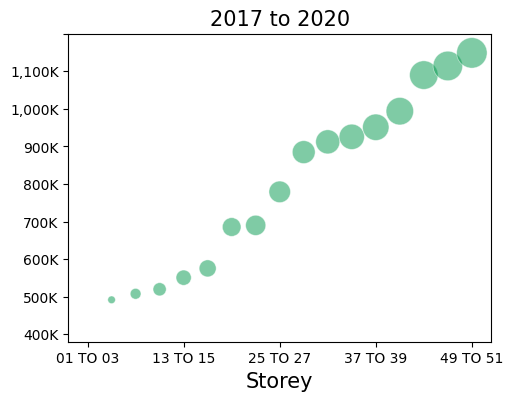

In [158]:
fig = plt.figure(figsize=(12,4))

# Floor Area Prices
plt1 = plt.subplot(122)
storey2 = df_price[df_price['year'].isin([2017,2018,2019,2020])].groupby('storey_range')['real_price'].median().reset_index().sort_values(by='storey_range')
storey2['storey_rank'] = storey2['storey_range'].astype('category').cat.codes

# Bubble chart
b=sns.scatterplot(x=storey2['storey_rank'], y=storey2['real_price'], s=storey2['storey_rank'].astype('int')*30, color='#00994d', edgecolors='w', alpha=0.5, ax=plt1)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in plt1.get_yticks()/1000]
plt1.set_yticklabels(ylabels); plt1.set_ylabel('')
plt1.set_xticks([0,4,8,12,16])
plt1.set_xticklabels(storey2.iloc[[0,4,8,12,16],0])
plt1.set_ylim([280000,1100000]), plt1.set_xlabel('Storey', size=15)
plt1.set_title('2017 to 2020', size=15)

plt.show()

By Floor Area

FixedFormatter should only be used together with FixedLocator


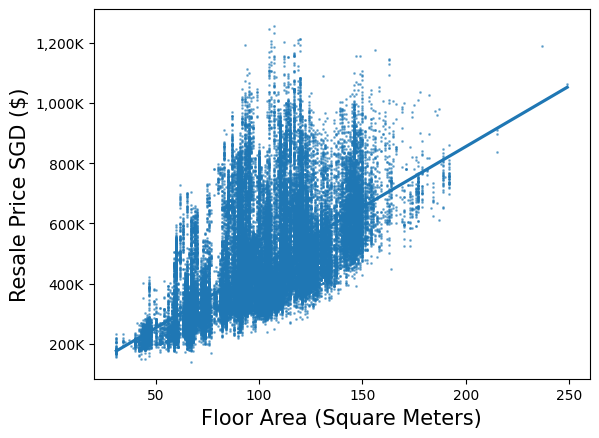

In [159]:
# Floor Area Prices
area = df_price[df_price['year'].isin([2017,2018,2019,2020])]
plt1=sns.regplot(x='floor_area_sqm', y='real_price', data=area, scatter_kws={"s": 1, 'alpha':0.5})
ylabels = ['{:,.0f}'.format(x) + 'K' for x in plt1.get_yticks()/1000]
plt1.set_yticklabels(ylabels)
plt1.set_ylabel('Resale Price SGD ($)', size=15)
plt1.set_xlabel('Floor Area (Square Meters)', size=15)
plt.show()

In [160]:
display(area[area['floor_area_sqm'] > 200])

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,cpi,real_price,year
8798,2017-06-01,KALLANG/WHAMPOA,3 ROOM,38,JLN BAHAGIA,01 TO 03,215.0,Terrace,1972,54.083333,830000.0,98.956,8.387566e+05,2017
13831,2017-09-01,CHOA CHU KANG,EXECUTIVE,641,CHOA CHU KANG ST 64,16 TO 18,215.0,Executive Maisonette,1998,79.333333,888000.0,99.036,8.966436e+05,2017
19527,2017-12-01,KALLANG/WHAMPOA,3 ROOM,65,JLN MA'MOR,01 TO 03,249.0,Terrace,1972,53.583333,1053888.0,99.225,1.062119e+06,2017
20656,2018-01-01,CHOA CHU KANG,EXECUTIVE,639,CHOA CHU KANG ST 64,10 TO 12,215.0,Executive Maisonette,1998,79.000000,900000.0,99.035,9.087696e+05,2018
35617,2018-09-01,KALLANG/WHAMPOA,3 ROOM,41,JLN BAHAGIA,01 TO 03,237.0,Terrace,1972,52.833333,1185000.0,99.753,1.187934e+06,2018


By FLat Model

FixedFormatter should only be used together with FixedLocator


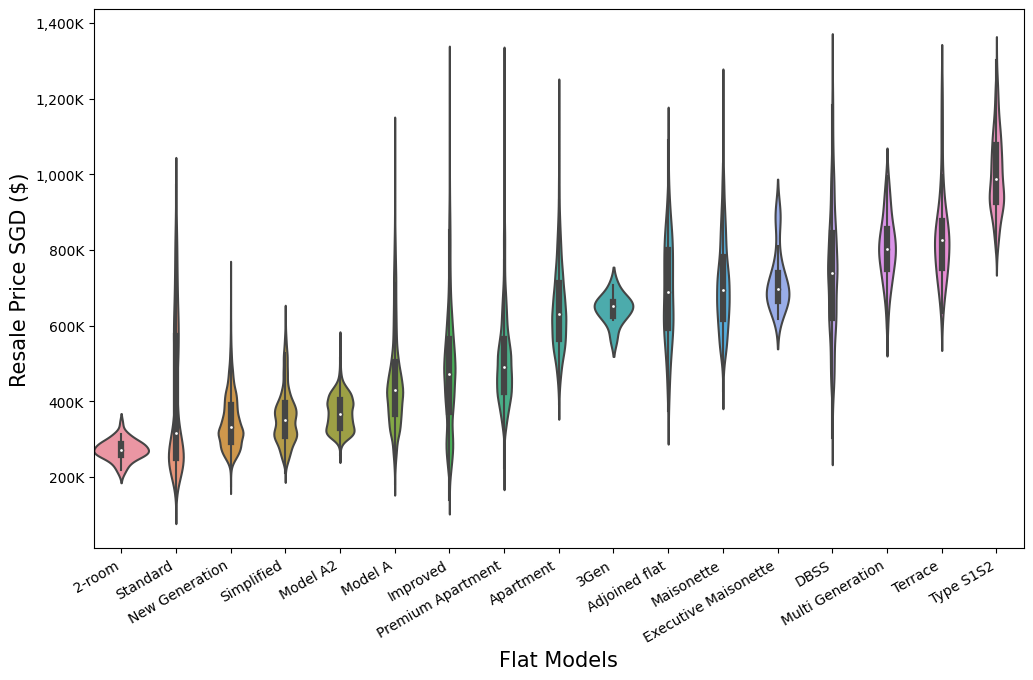

In [161]:
# Violin plots for price distribution of each flat model
fig = plt.figure(figsize=(12,7))
plt1=sns.violinplot(x='flat_model', y='real_price', data=df_price, width=1,
                order=df_price.groupby('flat_model')['real_price'].median().sort_values().reset_index()['flat_model'].tolist())
plt1.set_xticklabels(plt1.get_xticklabels(), rotation=30, ha='right'), plt1.set_xlabel('Flat Models', size=15)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in plt1.get_yticks()/1000]
plt1.set_yticklabels(ylabels)
plt1.set_ylabel('Resale Price SGD ($)', size=15)
plt.show()

The special models like the Type S1S2 (The Pinnacle@Duxton) and Terrace tend to fetch higher prices while the older models from the 1900s tend to go lower.

By Lease Commence Date

FixedFormatter should only be used together with FixedLocator


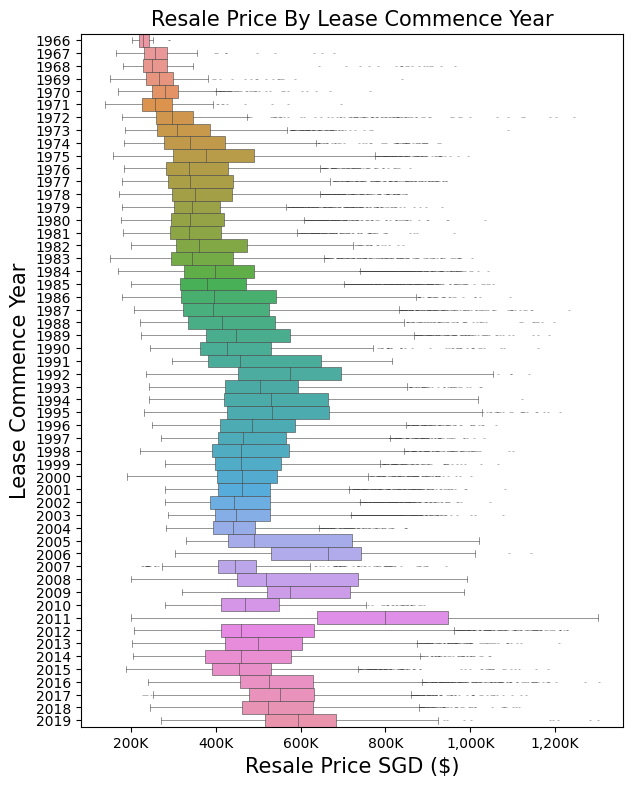

In [162]:
# Boxplot for each year of lease commence date
fig = plt.figure(figsize=(7,9))
plt1=sns.boxplot(y='lease_commence_date', x='real_price', data=df_price, width=1, orient='h', flierprops = dict(markerfacecolor = 'red', markersize = 0.1, linestyle='none'), linewidth=0.4)
plt1.set_xlabel('Resale Price SGD ($)', size=15), plt1.set_ylabel('Lease Commence Year', size=15)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in plt1.get_xticks()/1000]
plt1.set_xticklabels(xlabels)
plt1.set_title('Resale Price By Lease Commence Year', size=15)
plt.show()

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


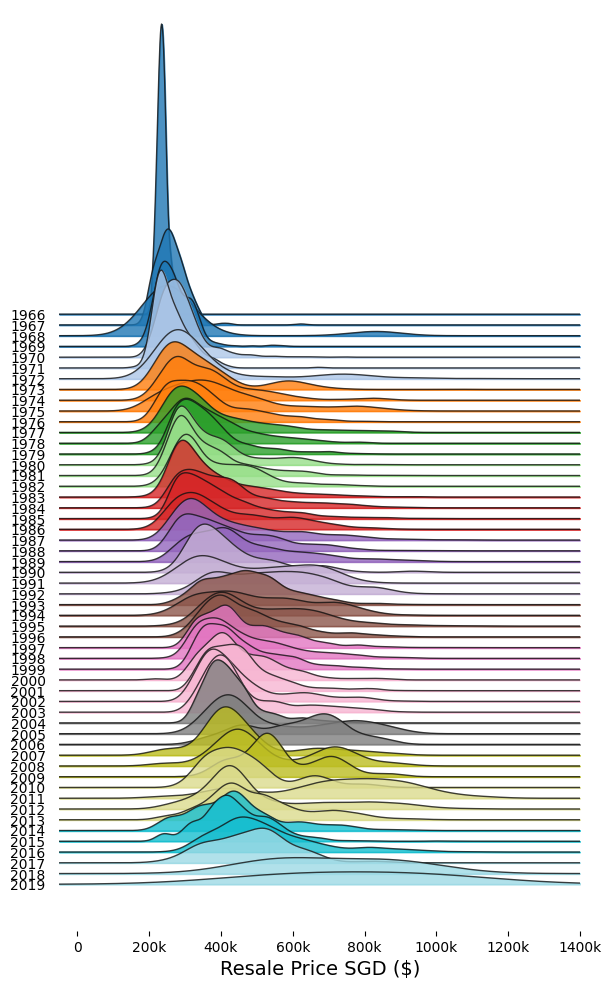

In [163]:
tmp = df_price[df_price['year'].isin([2017,2018,2019,2020])]
fig, plt1 = joypy.joyplot(tmp, by="lease_commence_date", column="real_price",figsize=(6,10),
             linewidth=1,overlap=5,alpha=0.8,colormap=plt.cm.get_cmap('tab20',16))
plt1[-1].set_xlim([-50000,1400000])
plt1[-1].set_xticklabels(['0', '200k', '400k', '600k', '800k', '1000k', '1200k', '1400k']) 
plt.xlabel('Resale Price SGD ($)', fontsize=14)
fig.show()

By Distance to Nearest Amenities

In [164]:
flat_amenities = pd.read_csv('data/flat_amenities.csv')

# merge amenities data to flat data
prices17to20 = df_price[df_price['year'].isin([2017,2018,2019,2020])]
prices17to20['flat'] = df_price['block'] + ' ' + df_price['street_name']
prices17to20 = prices17to20.merge(flat_amenities, on='flat', how='left')

# reduce number of class of town to regions
d_region = {'ANG MO KIO':'North East', 'BEDOK':'East', 'BISHAN':'Central', 'BUKIT BATOK':'West', 'BUKIT MERAH':'Central',
       'BUKIT PANJANG':'West', 'BUKIT TIMAH':'Central', 'CENTRAL AREA':'Central', 'CHOA CHU KANG':'West',
       'CLEMENTI':'West', 'GEYLANG':'Central', 'HOUGANG':'North East', 'JURONG EAST':'West', 'JURONG WEST':'West',
       'KALLANG/WHAMPOA':'Central', 'MARINE PARADE':'Central', 'PASIR RIS':'East', 'PUNGGOL':'North East',
       'QUEENSTOWN':'Central', 'SEMBAWANG':'North', 'SENGKANG':'North East', 'SERANGOON':'North East', 'TAMPINES':'East',
       'TOA PAYOH':'Central', 'WOODLANDS':'North', 'YISHUN':'North'}
prices17to20['region'] = prices17to20['town'].map(d_region)
colors = {'North East':'Purple', 'East':'Green', 'Central':'Brown', 'West':'Red', 'North':'Orange'}


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


FixedFormatter should only be used together with FixedLocator


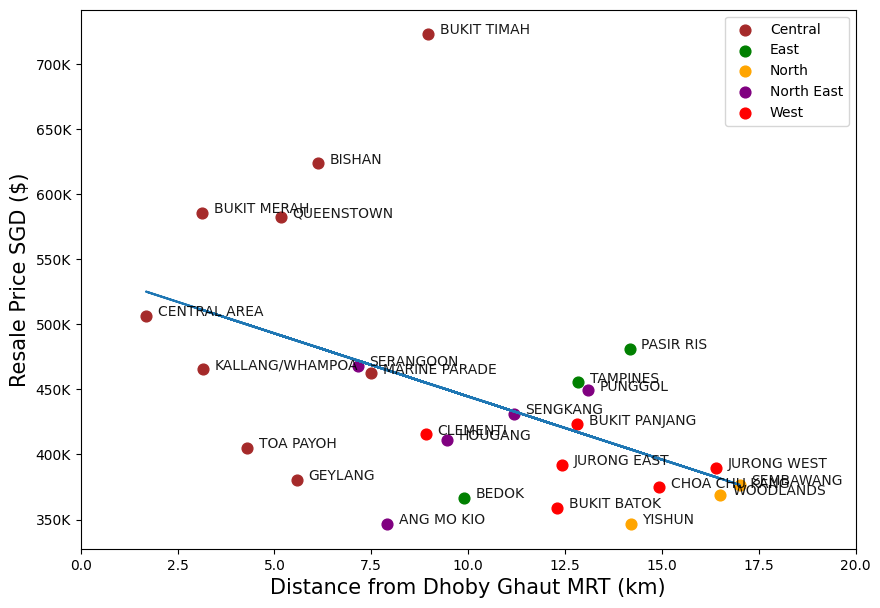

In [165]:
# get median info of each town
tmp = prices17to20.groupby('town')[['dist_dhoby','school_dist','num_school_2km','hawker_dist','num_hawker_2km','park_dist','num_park_2km','mall_dist','num_mall_2km','mrt_dist','num_mrt_2km','supermarket_dist','num_supermarket_2km','real_price']].median().reset_index()
tmp['region'] = tmp['town'].map(d_region)

# Scatterplot with names of towns
fig, plt1 = plt.subplots(figsize=(10,7))
grouped = tmp.groupby('region')
for key, group in grouped:
    group.plot(ax=plt1, kind='scatter', x='dist_dhoby', y='real_price', label=key, color=colors[key], s=60)
b, a = np.polyfit(tmp['dist_dhoby'], tmp['real_price'], 1)
plt1.plot(tmp['dist_dhoby'], a + b* tmp['dist_dhoby'], '-')  
plt1.set_xlim([0,20]), plt1.set_xlabel('Distance from Dhoby Ghaut MRT (km)', size=15)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in plt1.get_yticks()/1000]
plt1.set_yticklabels(ylabels), plt1.set_ylabel('Resale Price SGD ($)', size=15)
for i, txt in enumerate(tmp['town']):
    plt1.annotate(txt, (tmp['dist_dhoby'][i]+0.3, tmp['real_price'][i]), size=10, alpha=0.9)

plt.show()

In [166]:
prices17to20.groupby('region')['real_price'].median()

region
Central       516932.534638
East          437682.996770
North         363551.902083
North East    429366.447098
West          389930.154264
Name: real_price, dtype: float64

FixedFormatter should only be used together with FixedLocator


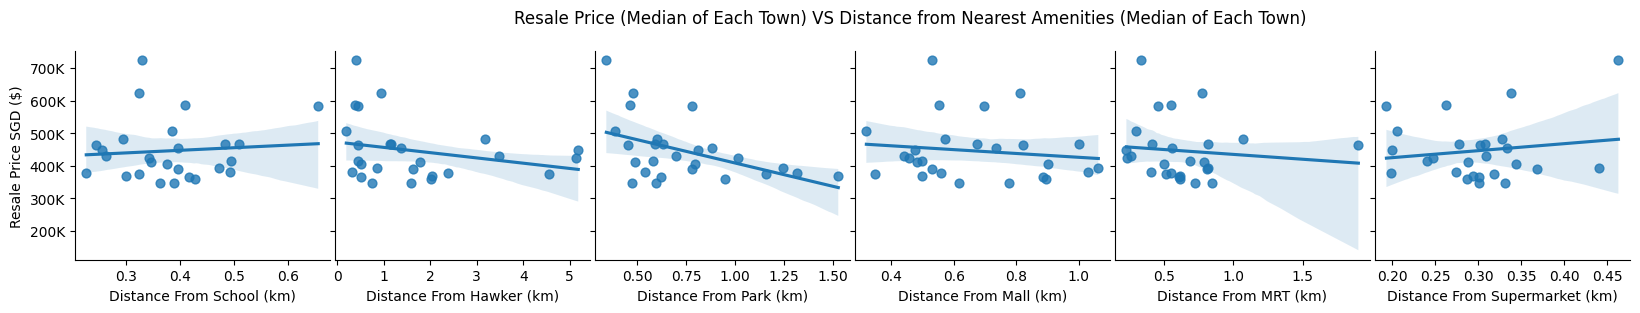

In [167]:
# scatterplot for median price of each town against nearest distance from each amenity

p=sns.pairplot(tmp, x_vars=["school_dist", "hawker_dist", "park_dist", "mall_dist", "mrt_dist", "supermarket_dist"], y_vars=["real_price"], height=3, aspect=1, kind="reg", plot_kws=dict(scatter_kws=dict(s=40)))
plt1=p.axes
ylabels = ['{:,.0f}'.format(x) + 'K' for x in plt1[0,0].get_yticks()/1000]
plt1[0,0].set_yticklabels(ylabels), plt1[0,0].set_ylabel('Resale Price SGD ($)', size=10)
plt1[0,0].set_xlabel('Distance From School (km)', size=10), plt1[0,1].set_xlabel('Distance From Hawker (km)', size=10)
plt1[0,2].set_xlabel('Distance From Park (km)', size=10), plt1[0,3].set_xlabel('Distance From Mall (km)', size=10)
plt1[0,4].set_xlabel('Distance From MRT (km)', size=10), plt1[0,5].set_xlabel('Distance From Supermarket (km)', size=10)
plt.suptitle('Resale Price (Median of Each Town) VS Distance from Nearest Amenities (Median of Each Town)')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

FixedFormatter should only be used together with FixedLocator


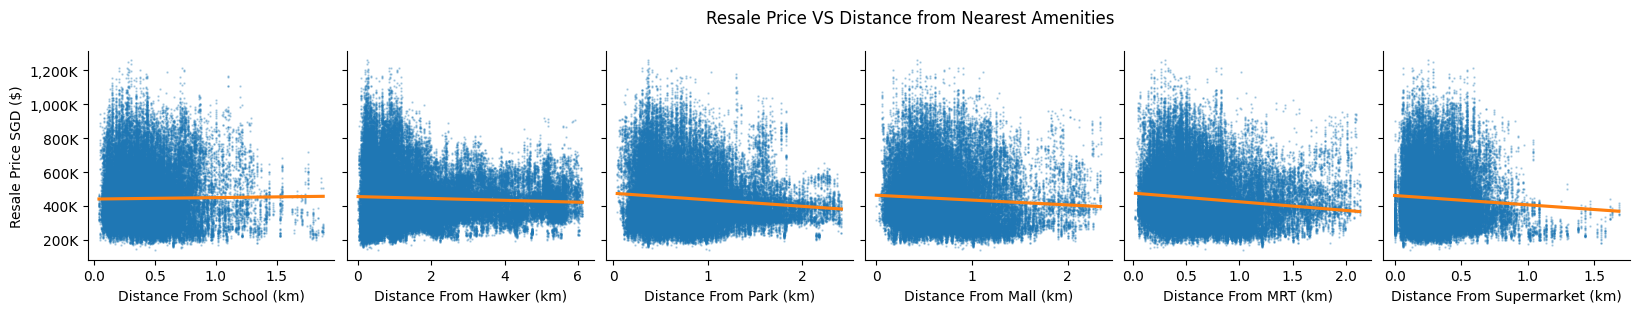

In [168]:
# scatterplot for price of each flat against nearest distance from each amenity

p=sns.pairplot(prices17to20[prices17to20['school_dist']<3], x_vars=["school_dist", "hawker_dist", "park_dist", "mall_dist", "mrt_dist", "supermarket_dist"], y_vars=["real_price"], height=3, aspect=1, kind="reg", plot_kws=dict(scatter_kws=dict(s=0.5,alpha=0.3), line_kws=dict(color='#ff7f0e'))) # remove outliers (>3km)
plt1=p.axes
ylabels = ['{:,.0f}'.format(x) + 'K' for x in plt1[0,0].get_yticks()/1000]
plt1[0,0].set_yticklabels(ylabels), plt1[0,0].set_ylabel('Resale Price SGD ($)', size=10)
plt1[0,0].set_xlabel('Distance From School (km)', size=10), plt1[0,1].set_xlabel('Distance From Hawker (km)', size=10)
plt1[0,2].set_xlabel('Distance From Park (km)', size=10), plt1[0,3].set_xlabel('Distance From Mall (km)', size=10)
plt1[0,4].set_xlabel('Distance From MRT (km)', size=10), plt1[0,5].set_xlabel('Distance From Supermarket (km)', size=10)
plt.suptitle('Resale Price VS Distance from Nearest Amenities')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

By Number of Amenities in 2km Radius

FixedFormatter should only be used together with FixedLocator


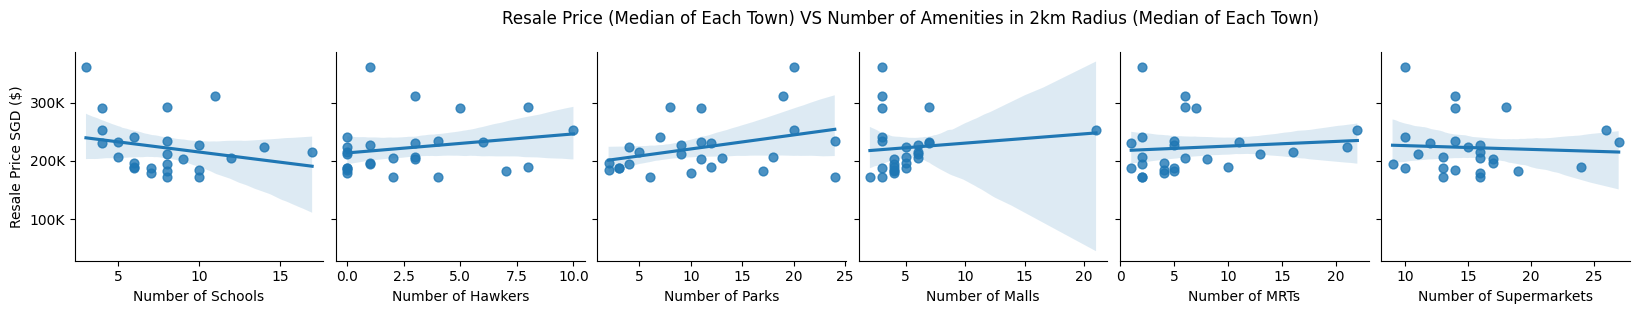

In [169]:
# scatterplot for median price of each town against number of amenities

p=sns.pairplot(tmp, x_vars=["num_school_2km", "num_hawker_2km", "num_park_2km", "num_mall_2km", "num_mrt_2km", "num_supermarket_2km"], y_vars=["real_price"], height=3, aspect=1, kind="reg", plot_kws=dict(scatter_kws=dict(s=40)))
plt1=p.axes
ylabels = ['{:,.0f}'.format(x) + 'K' for x in plt1[0,0].get_yticks()/1000]
plt1[0,0].set_yticklabels(ylabels), plt1[0,0].set_ylabel('Resale Price SGD ($)', size=10)
plt1[0,0].set_xlabel('Number of Schools', size=10), plt1[0,1].set_xlabel('Number of Hawkers', size=10)
plt1[0,2].set_xlabel('Number of Parks', size=10), plt1[0,3].set_xlabel('Number of Malls', size=10)
plt1[0,4].set_xlabel('Number of MRTs', size=10), plt1[0,5].set_xlabel('Number of Supermarkets', size=10)
plt.suptitle('Resale Price (Median of Each Town) VS Number of Amenities in 2km Radius (Median of Each Town)')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

FixedFormatter should only be used together with FixedLocator


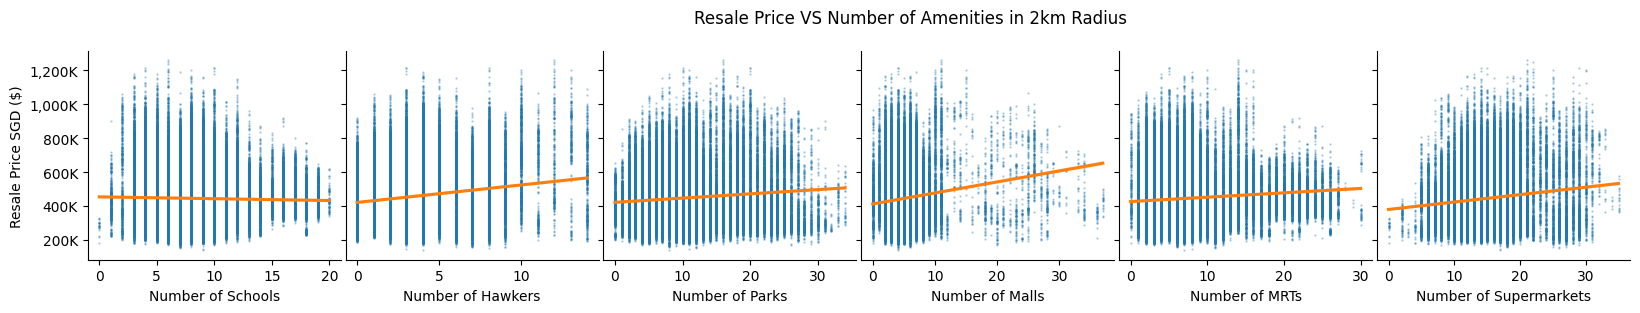

In [170]:
# scatterplot for price of each flat against number of amenities

p=sns.pairplot(prices17to20, x_vars=["num_school_2km", "num_hawker_2km", "num_park_2km", "num_mall_2km", "num_mrt_2km", "num_supermarket_2km"], y_vars=["real_price"], height=3, aspect=1, kind="reg", plot_kws=dict(scatter_kws=dict(s=0.5,alpha=0.3), line_kws=dict(color='#ff7f0e')))
plt1=p.axes
ylabels = ['{:,.0f}'.format(x) + 'K' for x in plt1[0,0].get_yticks()/1000]
plt1[0,0].set_yticklabels(ylabels), plt1[0,0].set_ylabel('Resale Price SGD ($)', size=10)
plt1[0,0].set_xlabel('Number of Schools', size=10), plt1[0,1].set_xlabel('Number of Hawkers', size=10)
plt1[0,2].set_xlabel('Number of Parks', size=10), plt1[0,3].set_xlabel('Number of Malls', size=10)
plt1[0,4].set_xlabel('Number of MRTs', size=10), plt1[0,5].set_xlabel('Number of Supermarkets', size=10)
plt.suptitle('Resale Price VS Number of Amenities in 2km Radius')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

Data Preparation

In [171]:
# clear unused variables
gc.collect()

238878

Missing Values Prep

In [172]:
df = prices17to20[['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'year', 'school_dist', 'num_school_2km', 'hawker_dist', 'num_hawker_2km', 'park_dist', 'num_park_2km', 'mall_dist', 'num_mall_2km', 'mrt_dist', 'num_mrt_2km', 'supermarket_dist', 'num_supermarket_2km', 'dist_dhoby', 'region', 'real_price']]

# function for replacing NAs with median of the town
def replace_NA_median(df, columns):
    for c in columns:
        if df[c].dtype != 'object':  # Skip non-numeric columns
            df[c] = df.groupby("town")[c].transform(lambda x: x.fillna(x.median()))
    return df

df = replace_NA_median(df, ['school_dist', 'num_school_2km', 'hawker_dist',
       'num_hawker_2km', 'park_dist', 'num_park_2km', 'mall_dist',
       'num_mall_2km', 'mrt_dist', 'num_mrt_2km', 'supermarket_dist',
       'num_supermarket_2km', 'dist_dhoby'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87370 entries, 0 to 87369
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   town                 87370 non-null  object 
 1   flat_type            87370 non-null  object 
 2   storey_range         87370 non-null  object 
 3   floor_area_sqm       87370 non-null  float64
 4   flat_model           87370 non-null  object 
 5   lease_commence_date  87370 non-null  int64  
 6   year                 87370 non-null  int32  
 7   school_dist          87370 non-null  float64
 8   num_school_2km       87370 non-null  float64
 9   hawker_dist          87370 non-null  float64
 10  num_hawker_2km       87370 non-null  float64
 11  park_dist            87370 non-null  float64
 12  num_park_2km         87370 non-null  float64
 13  mall_dist            87370 non-null  float64
 14  num_mall_2km         87370 non-null  float64
 15  mrt_dist             87370 non-null 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Multicollinearity

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


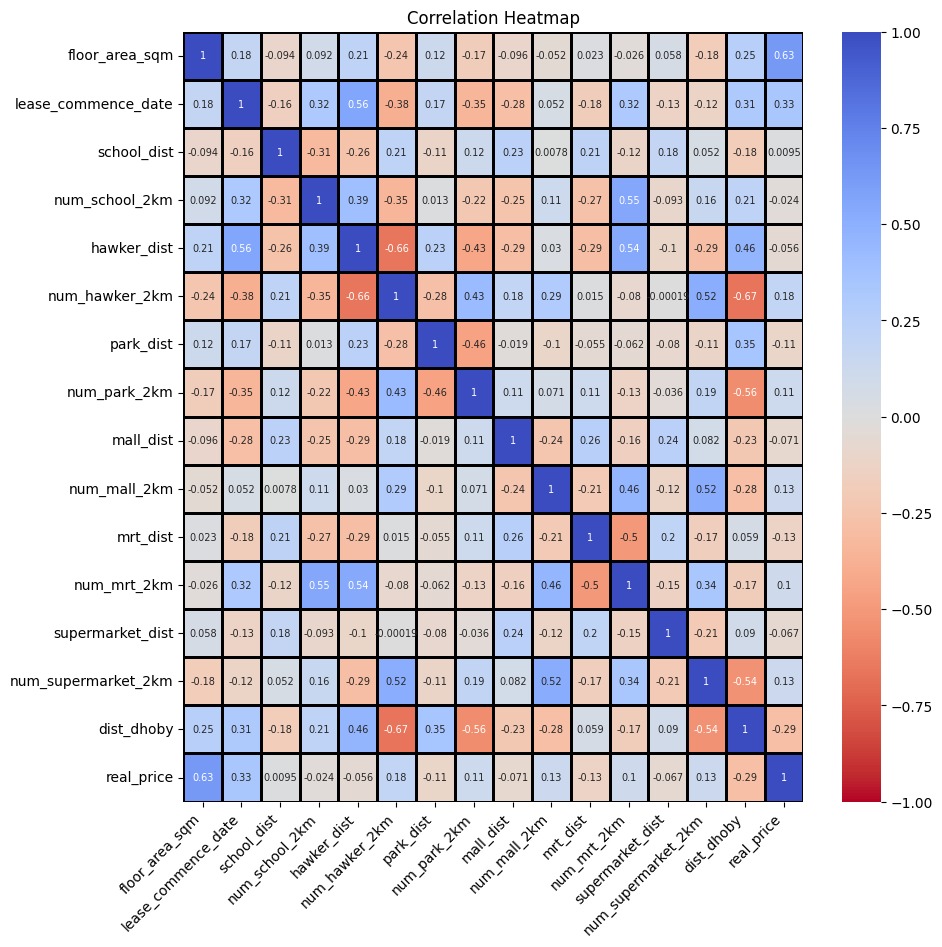

In [173]:
# Correlation heatmap
fig = plt.figure(figsize=(10,10))
plt1 = sns.heatmap(df.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1, annot_kws={"size": 7})
#ax.set_ylim(0 ,5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
fig.show()

In [174]:
# Multicollinearity

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif)

calc_vif(df.drop('real_price',axis=1).select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
0,floor_area_sqm,18.996611,0.052641,18.062206
1,lease_commence_date,117.056240,0.008543,18.062206
2,school_dist,4.728432,0.211487,18.062206
3,num_school_2km,15.855089,0.063071,18.062206
4,hawker_dist,11.018899,0.090753,18.062206
5,num_hawker_2km,5.252913,0.190371,18.062206
6,park_dist,6.182296,0.161752,18.062206
7,num_park_2km,5.028718,0.198858,18.062206
8,mall_dist,5.950318,0.168058,18.062206
9,num_mall_2km,6.703573,0.149174,18.062206


In [175]:
calc_vif(df.drop(['real_price','num_supermarket_2km','year','num_school_2km','dist_dhoby'],axis=1).select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
0,floor_area_sqm,18.900007,0.052910,10.595757
1,lease_commence_date,53.610462,0.018653,10.595757
2,school_dist,4.366602,0.229011,10.595757
3,hawker_dist,8.864878,0.112805,10.595757
4,num_hawker_2km,4.084339,0.244838,10.595757
5,park_dist,6.066409,0.164842,10.595757
6,num_park_2km,4.223010,0.236798,10.595757
7,mall_dist,5.473060,0.182713,10.595757
8,num_mall_2km,5.736860,0.174311,10.595757
9,mrt_dist,5.287588,0.189122,10.595757


In [176]:
# drop columns
lr_df = df.drop(['num_supermarket_2km','year','num_school_2km','dist_dhoby'], axis=1)

Normality

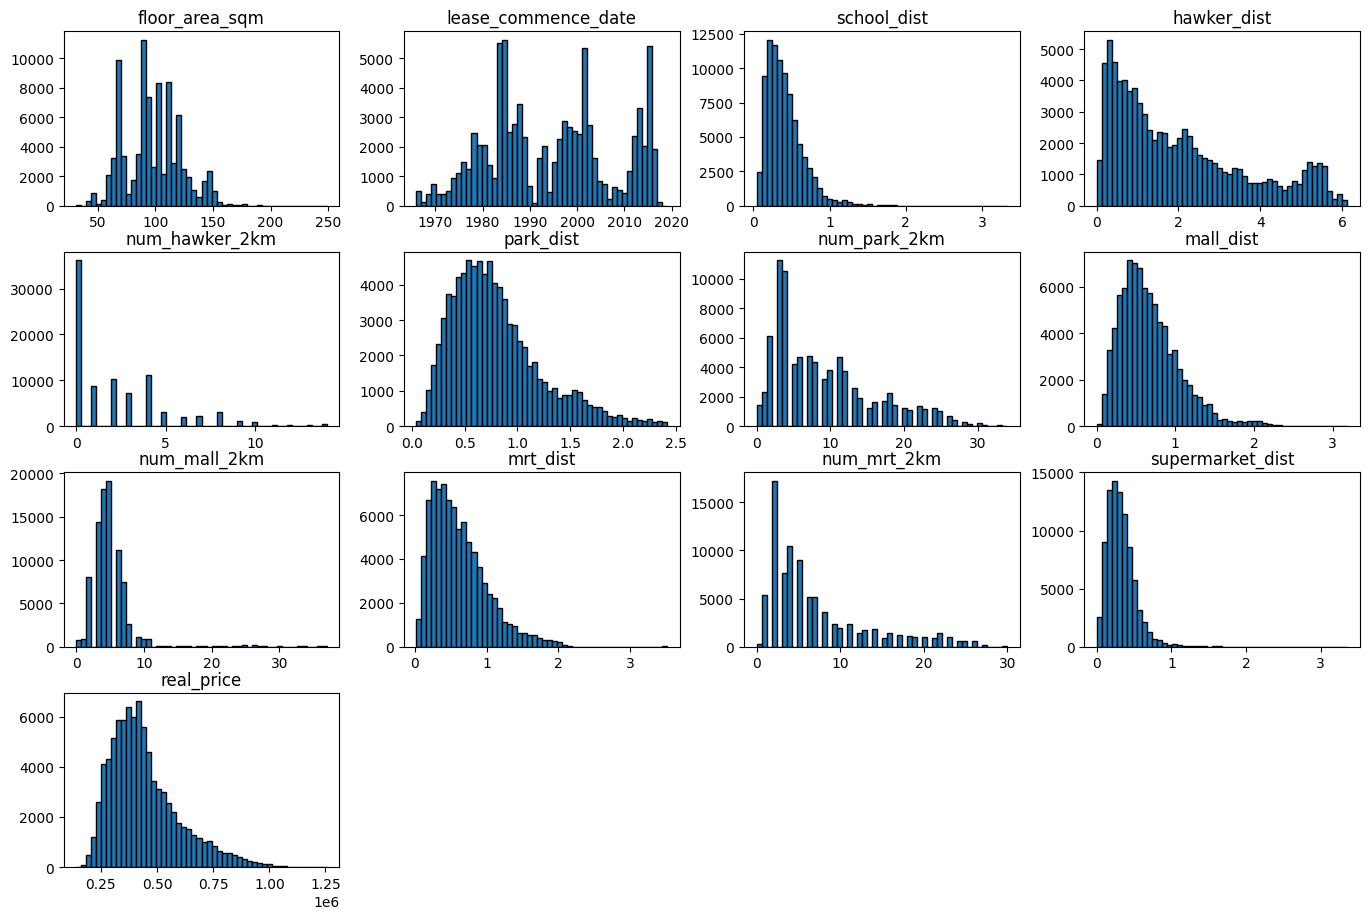

In [177]:
# Plot distribution for each continuous variable
lr_df.hist(bins=50, figsize=(15, 10), grid=False, edgecolor='black')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

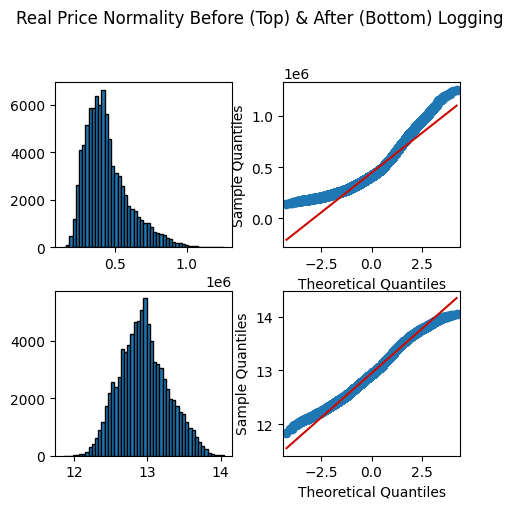

In [178]:
fig, ((plt1,plt2), (plt3,plt4)) = plt.subplots(2,2,figsize=(5,5))

plt1.hist(lr_df['real_price'], bins=50, edgecolor='black')
qqplot(lr_df['real_price'], line='s', ax=plt2)
plt3.hist(np.log(lr_df['real_price']), bins=50, edgecolor='black')
qqplot(np.log(lr_df['real_price']), line='s', ax=plt4)
plt.suptitle('Real Price Normality Before (Top) & After (Bottom) Logging')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

Label & Dummy Encoding

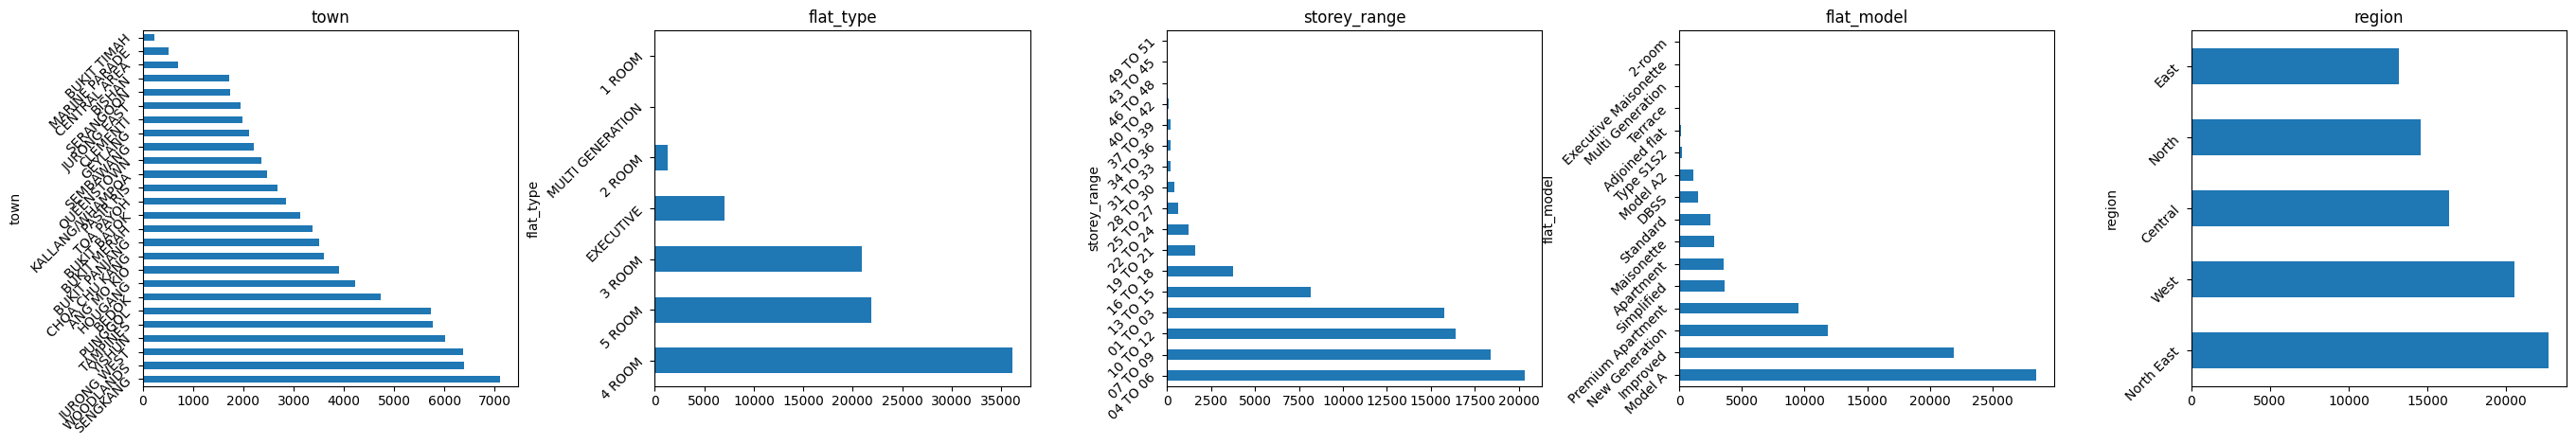

In [179]:
fig = plt.figure(figsize=(30,5))
for count, col in enumerate(df.select_dtypes(include=['category','object']).columns):
    fig.add_subplot(1,5,count+1)
    df[col].value_counts().plot.barh()
    plt.title(col)
    plt.yticks(rotation=45)
    plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])

In [180]:
# label encode storeys
df = df.sort_values(by='storey_range')
df['storey_range'] = df['storey_range'].astype('category').cat.codes # label encode
lr_df = lr_df.sort_values(by='storey_range')
lr_df['storey_range'] = lr_df['storey_range'].astype('category').cat.codes # label encode

# remove flat types with very few cases
df = df[~df['flat_type'].isin(['MULTI GENERATION', '1 ROOM'])]
lr_df = lr_df[~lr_df['flat_type'].isin(['MULTI GENERATION', '1 ROOM'])]

# Re-categorize flat model to reduce num classes
replace_values = {'Executive Maisonette':'Maisonette', 'Terrace':'Special', 'Adjoined flat':'Special', 
                    'Type S1S2':'Special', 'DBSS':'Special', 'Model A2':'Model A', 'Premium Apartment':'Apartment', 'Improved':'Standard', 'Simplified':'Model A', '2-room':'Standard'}
df = df.replace({'flat_model': replace_values})
lr_df = lr_df.replace({'flat_model': replace_values})

# Label encode flat type
replace_values = {'2 ROOM':0, '3 ROOM':1, '4 ROOM':2, '5 ROOM':3, 'EXECUTIVE':4}
df = df.replace({'flat_type': replace_values})
lr_df = lr_df.replace({'flat_type': replace_values})

df = df.reset_index(drop=True)
display(df['flat_model'].value_counts())
lr_df = lr_df.reset_index(drop=True)
display(lr_df['flat_model'].value_counts())

flat_model
Model A           33209
Standard          24332
Apartment         13115
New Generation    11884
Maisonette         2806
Special            1945
Name: count, dtype: int64

flat_model
Model A           33209
Standard          24332
Apartment         13115
New Generation    11884
Maisonette         2806
Special            1945
Name: count, dtype: int64

In [181]:
display(lr_df.head())

,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,school_dist,hawker_dist,num_hawker_2km,park_dist,num_park_2km,mall_dist,num_mall_2km,mrt_dist,num_mrt_2km,supermarket_dist,region,real_price
0,BUKIT BATOK,4,0,147.0,Maisonette,1986,0.433594,2.496861,0.0,0.899396,10.0,1.373577,4.0,0.479722,7.0,0.316030,West,524309.826776
1,WOODLANDS,3,0,122.0,Standard,1998,0.180590,2.036134,0.0,1.476949,2.0,0.591351,5.0,0.570101,5.0,0.268743,North,388736.606030
2,BISHAN,3,0,121.0,Standard,1987,0.240374,1.163543,5.0,0.725490,19.0,0.451395,1.0,0.381918,5.0,0.303182,Central,673360.066733
3,BISHAN,2,0,105.0,Model A,1990,0.316017,0.942894,2.0,0.320529,25.0,0.467661,1.0,1.393123,1.0,0.375812,Central,527632.888112
4,BISHAN,2,0,84.0,Model A,1986,0.172928,1.012377,5.0,0.432426,18.0,0.293982,2.0,0.372614,7.0,0.055708,Central,482407.211988


In [182]:
## dummy encoding
df = pd.get_dummies(df, columns=['region'], prefix=['region'], drop_first=True) # central is baseline
df = pd.get_dummies(df, columns=['flat_model'], prefix=['model'])
df= df.drop('model_Standard',axis=1) # remove standard, setting it as the baseline
lr_df = pd.get_dummies(lr_df, columns=['region'], prefix=['region'], drop_first=True) # central is baseline
lr_df = pd.get_dummies(lr_df, columns=['flat_model'], prefix=['model'])
lr_df= lr_df.drop('model_Standard',axis=1) # remove standard, setting it as the baseline

Region and flat_model were dummy encoded, with Central region and Standard model selected as the baseline to which other classes are compared to.

Feature Scaling
Scaling is only done for linear regression. Tree-based models do not require scaling as it does not affect performance.
(so maybe can delete if using forest)

In [183]:
scaler = StandardScaler()

# fit to continuous columns and transform
scaled_columns = ['floor_area_sqm','lease_commence_date','school_dist','hawker_dist','num_hawker_2km','park_dist',
                    'num_park_2km', 'mall_dist', 'num_mall_2km', 'mrt_dist', 'num_mrt_2km', 'supermarket_dist']
scaler.fit(lr_df[scaled_columns])
scaled_columns = pd.DataFrame(scaler.transform(lr_df[scaled_columns]), index=lr_df.index, columns=scaled_columns)

# separate unscaled features
unscaled_columns = lr_df.drop(scaled_columns, axis=1)

# concatenate scaled and unscaled features
lr_df = pd.concat([scaled_columns,unscaled_columns], axis=1)
display(lr_df.head())


,floor_area_sqm,lease_commence_date,school_dist,hawker_dist,num_hawker_2km,park_dist,num_park_2km,mall_dist,num_mall_2km,mrt_dist,...,real_price,region_East,region_North,region_North East,region_West,model_Apartment,model_Maisonette,model_Model A,model_New Generation,model_Special
0,2.035195,-0.641321,0.122118,0.298683,-0.814728,0.233200,0.132426,1.861836,-0.310068,-0.359203,...,524309.826776,False,False,False,True,False,True,False,False,False
1,1.002693,0.283021,-0.921930,0.013561,-0.814728,1.576065,-1.030113,-0.200913,0.010807,-0.126084,...,388736.606030,False,True,False,False,False,False,False,False,False
2,0.961392,-0.564292,-0.675227,-0.526443,0.984764,-0.171145,1.440281,-0.569978,-1.272692,-0.611474,...,673360.066733,False,False,False,False,False,False,False,False,False
3,0.300591,-0.333207,-0.363076,-0.662991,-0.094931,-1.112718,2.312185,-0.527086,-1.272692,1.996784,...,527632.888112,False,False,False,False,False,False,True,False,False
4,-0.566712,-0.641321,-0.953549,-0.619992,0.984764,-0.852547,1.294964,-0.985080,-0.951817,-0.635474,...,482407.211988,False,False,False,False,False,False,True,False,False


OUTLIER DETECTION

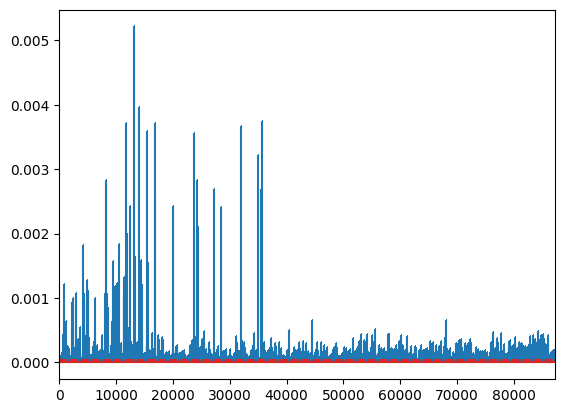

In [184]:
lr_y = lr_df[['real_price']]
lr_X = lr_df.drop(['real_price','town'], axis=1)

yy = np.log(lr_y)['real_price']
XX = lr_X.values.astype(np.float64) 

visualizer = CooksDistance()
visualizer.fit(XX, yy)
#visualizer.show()
plt.show()

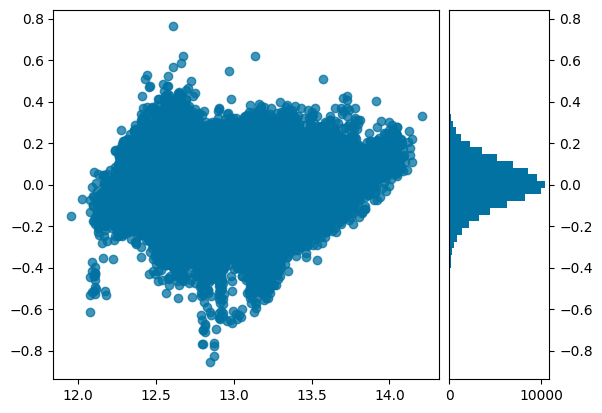

In [185]:
# visualize residuals before outlier removal
model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(XX, yy)
#visualizer_residuals.show()
plt.show()

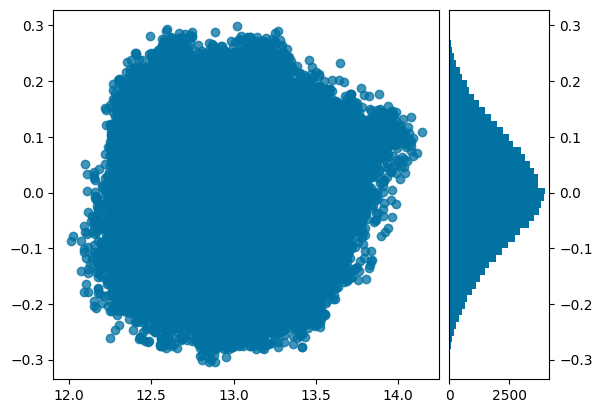

In [186]:
# remove outliers
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_li, y_li = XX[i_less_influential], yy[i_less_influential]
lr_X, lr_y = lr_X[i_less_influential], lr_y[i_less_influential]

# visualize residuals after outliers removal
model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_li, y_li)
#visualizer_residuals.show()
plt.show()

X_li and y_li is without outliers
XX and yy is with outliers

Models

Linear Regression Without Outlier

In [187]:
X_constant = sm.add_constant(lr_X)
lin_reg = sm.OLS(np.log(lr_y.astype(np.float64)), X_constant.astype(np.float64)).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             real_price   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 3.238e+04
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        01:16:49   Log-Likelihood:                 72778.
No. Observations:               82805   AIC:                        -1.455e+05
Df Residuals:                   82781   BIC:                        -1.453e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.9401      0.004   3529.194      0.000      12.933      12.947
floor_area_sqm           0.2003      0.001    151.675      0.000       0.198       0.203
lease_commence_date      0.1439      0.001    258.636      0.000       0.143       0.145
school_dist              0.0082      0.000     20.823      0.000       0.007       0.009
hawker_dist             -0.0748      0.001   -104.054      0.000      -0.076      -0.073
num_hawker_2km           0.0146      0.001     23.292      0.000       0.013       0.016
park_dist               -0.0109      0.000    -26.556      0.000      -0.012      -0.010
num_park_2km             0.0304      0.001     57.931      0.000       0.029       0.031
mall_dist               -0.0097      0.000    -22.707      0.000      -0.011      -0.009
num_mall_2km            -0.0072      0.001    -14.345      0.000      -0.008      -0.006
mrt_dist                -0.0369      0.000    -82.096      0.000      -0.038      -0.036
num_mrt_2km              0.0123      0.001     16.981      0.000       0.011       0.014
supermarket_dist        -0.0160      0.000    -41.096      0.000      -0.017      -0.015
flat_type                0.0529      0.001     35.308      0.000       0.050       0.056
storey_range             0.0248      0.000    121.164      0.000       0.024       0.025
region_East             -0.1572      0.001   -107.094      0.000      -0.160      -0.154
region_North            -0.3388      0.002   -200.315      0.000      -0.342      -0.335
region_North East       -0.2308      0.002   -146.245      0.000      -0.234      -0.228
region_West             -0.2484      0.002   -156.389      0.000      -0.252      -0.245
model_Apartment          0.0283      0.001     22.649      0.000       0.026       0.031
model_Maisonette         0.0704      0.002     30.656      0.000       0.066       0.075
model_Model A            0.0362      0.001     33.544      0.000       0.034       0.038
model_New Generation     0.0792      0.001     56.482      0.000       0.076       0.082
model_Special            0.1926      0.003     67.203      0.000       0.187       0.198
==============================================================================
Omnibus:                      645.829   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              441.384
Skew:                           0.039   Prob(JB):                     1.43e-96
Kurtosis:                       2.651   Cond. No.                         43.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With Outliers

In [188]:
X_constant = sm.add_constant(XX)
lin_reg2 = sm.OLS(np.log(yy.astype(np.float64)), X_constant.astype(np.float64)).fit()
lin_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             real_price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                 2.524e+04
Date:                Fri, 14 Jul 2023   Prob (F-statistic):               0.00
Time:                        01:16:50   Log-Likelihood:             2.8591e+05
No. Observations:               87291   AIC:                        -5.718e+05
Df Residuals:                   87267   BIC:                        -5.715e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5605      0.000   8141.048      0.000       2.560       2.561
x1             0.0155      0.000    138.124      0.000       0.015       0.016
x2             0.0107   4.88e-05    220.201      0.000       0.011       0.011
x3             0.0007    3.4e-05     20.045      0.000       0.001       0.001
x4            -0.0053   6.36e-05    -83.349      0.000      -0.005      -0.005
x5             0.0010   5.43e-05     19.072      0.000       0.001       0.001
x6            -0.0009   3.66e-05    -24.373      0.000      -0.001      -0.001
x7             0.0024   4.58e-05     53.466      0.000       0.002       0.003
x8            -0.0008   3.75e-05    -20.293      0.000      -0.001      -0.001
x9            -0.0002   4.15e-05     -4.413      0.000      -0.000      -0.000
x10           -0.0025   3.86e-05    -65.003      0.000      -0.003      -0.002
x11            0.0003   6.37e-05      4.841      0.000       0.000       0.000
x12           -0.0011   3.33e-05    -33.278      0.000      -0.001      -0.001
x13            0.0043      0.000     33.477      0.000       0.004       0.005
x14            0.0019   1.77e-05    105.055      0.000       0.002       0.002
x15           -0.0128      0.000    -99.954      0.000      -0.013      -0.013
x16           -0.0269      0.000   -182.175      0.000      -0.027      -0.027
x17           -0.0174      0.000   -126.085      0.000      -0.018      -0.017
x18           -0.0195      0.000   -141.832      0.000      -0.020      -0.019
x19            0.0016      0.000     14.703      0.000       0.001       0.002
x20            0.0037      0.000     18.865      0.000       0.003       0.004
x21            0.0026   9.54e-05     26.734      0.000       0.002       0.003
x22            0.0055      0.000     44.539      0.000       0.005       0.006
x23            0.0147      0.000     63.256      0.000       0.014       0.015
==============================================================================
Omnibus:                     3159.019   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5918.298
Skew:                           0.285   Prob(JB):                         0.00
Kurtosis:                       4.141   Cond. No.                         42.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

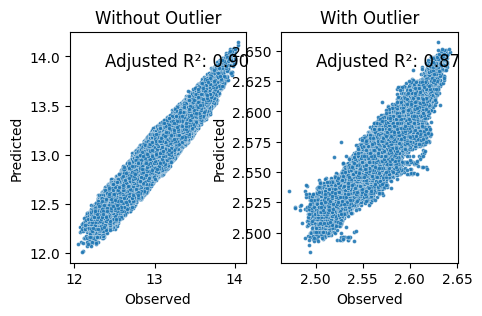

In [189]:
plt.style.use('default')
fig = plt.figure(figsize=(5,3))
ax = plt.subplot(121)
ax = sns.scatterplot(x=np.log(lr_y)['real_price'], y=lin_reg.predict(), edgecolors='w', alpha=0.9, s=8)
ax.set_xlabel('Observed')#, ax.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000])
ax.set_ylabel('Predicted')#, ax.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000])
ax.set_title('Without Outlier')
ax.annotate('Adjusted R\u00b2: ' + str(format(round(lin_reg.rsquared_adj,2),'.2f')), xy=(0, 1), xytext=(25, -25),
    xycoords='axes fraction', textcoords='offset points', fontsize=12)

ax = plt.subplot(122)
ax = sns.scatterplot(x=np.log(yy), y=lin_reg2.predict(), edgecolors='w', alpha=0.9, s=8)
ax.set_xlabel('Observed')#, ax.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000])
ax.set_ylabel('Predicted')#, ax.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000])
ax.set_title('With Outlier')
ax.annotate('Adjusted R\u00b2: ' + str(format(round(lin_reg2.rsquared_adj,2),'.2f')), xy=(0, 1), xytext=(25, -25),
    xycoords='axes fraction', textcoords='offset points', fontsize=12)
plt.show()

Therefore, when using Linear Regression, without Outliers will have a higher R2 score.

Random Forest

In [190]:
# Train Test Split
y = df[['real_price']]
X = df.drop(['real_price','town', 'year'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, shuffle=True, random_state=0)
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (61103, 26)
Shape of X_test: (26188, 26)
Shape of y_train: (61103, 1)
Shape of y_test: (26188, 1)


Using Out of bag to see performance of Random Forest

In [191]:
# Validation using out-of-bag method
rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=0)
rf.fit(X_train, y_train)
predicted_train = rf.predict(X_train)

print(f'Out-of-bag R\u00b2 score estimate: {rf.oob_score_:>5.3}')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Out-of-bag R² score estimate: 0.965


In [192]:
# predict and get evaluation metrics on test set
predicted_test = rf.predict(X_test)
oob_test_score = r2_score(y_test['real_price'], predicted_test)
spearman = spearmanr(y_test['real_price'], predicted_test)
pearson = pearsonr(y_test['real_price'], predicted_test)
oob_mae = mean_absolute_error(y_test['real_price'], predicted_test)

print(f'Test data R\u00b2 score: {oob_test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')
print(f'Test data Mean Absolute Error: {round(oob_mae)}')

Test data R² score: 0.966
Test data Spearman correlation: 0.979
Test data Pearson correlation: 0.983
Test data Mean Absolute Error: 20966


K-fold Cross Validation to evaluate Random Forest Model

In [193]:
# validation by k-fold cross validation with grid search for best hyperparameters
# hyperparameter values shown below are the tuned final values
param_grid = {
    #'max_features': ['auto'], # max number of features considered for splitting a node
    'max_depth': [20], # max number of levels in each decision tree
    'min_samples_split': [15], # min number of data points placed in a node before the node is split
    'min_samples_leaf': [2]} # min number of data points allowed in a leaf node
rfr =GridSearchCV(RandomForestRegressor(n_estimators = 500, n_jobs=-1, random_state=0),
                        param_grid, cv=10, scoring='r2', return_train_score=True)
rfr.fit(X_train,y_train)
print("Best parameters set found on Cross Validation:\n\n", rfr.best_params_)
print("\nCross Validation R\u00b2 score:\n\n", rfr.best_score_.round(3))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

Best parameters set found on Cross Validation:

 {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 15}

Cross Validation R² score:

 0.967


In [194]:
cv_predicted_test = rfr.predict(X_test)

cv_test_score = r2_score(y_test['real_price'], cv_predicted_test)
spearman = spearmanr(y_test['real_price'], cv_predicted_test)
pearson = pearsonr(y_test['real_price'], cv_predicted_test)
cv_mae = mean_absolute_error(y_test['real_price'], cv_predicted_test)

print(f'Test data R\u00b2 score: {cv_test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')
print(f'Test data Mean Absolute Error: {round(cv_mae)}')

Test data R² score: 0.967
Test data Spearman correlation: 0.981
Test data Pearson correlation: 0.984
Test data Mean Absolute Error: 20339


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


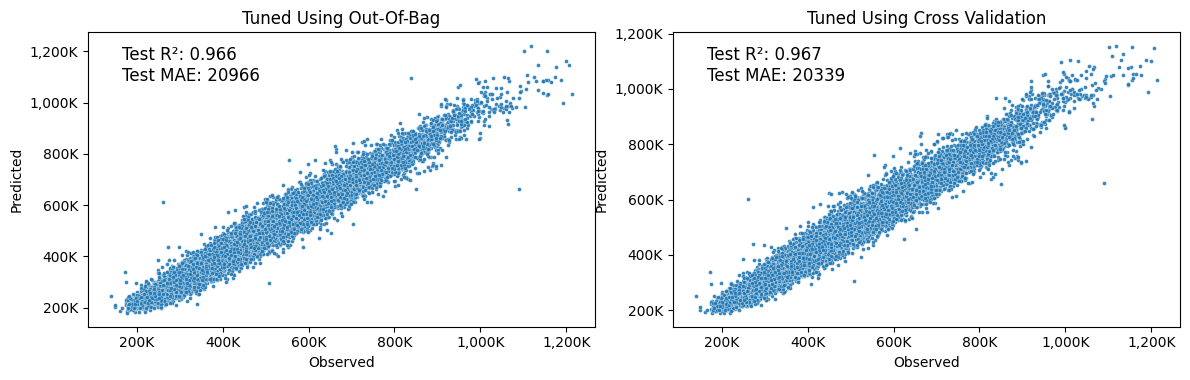

In [195]:
# scatterplots of y (observed) and yhat (predicted)

fig = plt.figure(figsize=(13,4))

ax1 = plt.subplot(121)
ax1 = sns.scatterplot(x=y_test['real_price'], y=predicted_test, edgecolors='w', alpha=0.9, s=8)
ax1.set_xlabel('Observed'), ax1.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax1.get_xticks()/1000])
ax1.set_ylabel('Predicted'), ax1.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax1.get_yticks()/1000])
ax1.annotate('Test R\u00b2: ' + str(round(oob_test_score,3)) + '\nTest MAE: ' + str(round(oob_mae)), xy=(0, 1), xytext=(25, -35),
    xycoords='axes fraction', textcoords='offset points', fontsize=12)
ax1.set_title('Tuned Using Out-Of-Bag')

ax2 = plt.subplot(122)
ax2 = sns.scatterplot(x=y_test['real_price'], y=cv_predicted_test, edgecolors='w', alpha=0.9, s=8)
ax2.set_xlabel('Observed'), ax2.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax2.get_xticks()/1000])
ax2.set_ylabel('Predicted'), ax2.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax2.get_yticks()/1000])
ax2.annotate('Test R\u00b2: ' + str(round(cv_test_score,3)) + '\nTest MAE: ' + str(round(cv_mae)), xy=(0, 1), xytext=(25, -35),
    xycoords='axes fraction', textcoords='offset points', fontsize=12)
ax2.set_title('Tuned Using Cross Validation')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

what features are important

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


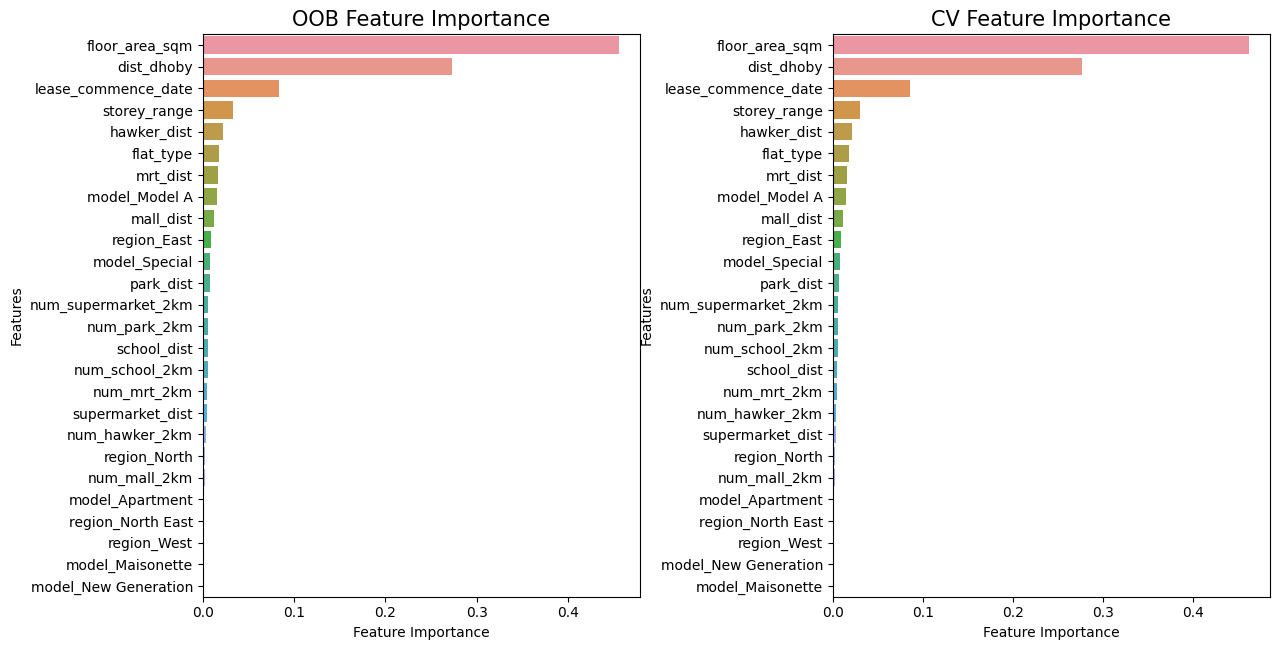

In [196]:
fig = plt.figure(figsize=(14,7))

ax1 = plt.subplot(121)
feat_imp = pd.DataFrame({'Features': X_train.columns, 'Feature Importance': rf.feature_importances_}).sort_values('Feature Importance', ascending=False)
sns.barplot(y='Features', x='Feature Importance', data=feat_imp)
#plt.xticks(rotation=45, ha='right')
ax1.set_title('OOB Feature Importance', size=15)

ax2 = plt.subplot(122)
feat_imp = pd.DataFrame({'Features': X_train.columns, 'Feature Importance': rfr.best_estimator_.feature_importances_}).sort_values('Feature Importance', ascending=False)
sns.barplot(y='Features', x='Feature Importance', data=feat_imp)
ax2.set_title('CV Feature Importance', size=15)

plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
fig.show()

The feature importance are abit different from the linear regression model. Floor area and lease commence date are still one of the main drivers of resale prices. However, features like distance from Dhoby Ghaut MRT and flat type also appears to be good drivers.

Tree-based models seem to give lower importance to categorical values. This is due to the importance score being a measure of how often the feature was selected for splitting and how much gain in purity was achieved as a result of the selection.

However, Random Forest still works better as compared to Linear Regression (with or without outliers).

Save Model

In [197]:
# Save model

# pickle.dump(rfr.best_estimator_, open('hdb_prices_rf_model.sav', 'wb'))
joblib.dump(rfr.best_estimator_, 'model/rf_compressed.pkl', compress=3) # smaller size

['model/rf_compressed.pkl']

In [198]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(rfr.best_estimator_)
shap_values = explainer.shap_values(X_test.iloc[[16]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[16]])

In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
explainer = shap.TreeExplainer(rfr.best_estimator_)
shap_values = explainer.shap_values(X_test.iloc[[5]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[5]])

In [ ]:
explainer = shap.TreeExplainer(rfr.best_estimator_)
shap_values = explainer.shap_values(X_test.iloc[[1]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[1]])

In [ ]:
explainer = shap.TreeExplainer(rfr.best_estimator_)
shap_values = explainer.shap_values(X_test.iloc[[100]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[100]])

In [ ]:
explainer = shap.TreeExplainer(rfr.best_estimator_)
shap_values = explainer.shap_values(X_test.iloc[[172]])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[172]])

In [ ]:
print("Flat Type Encoding = 2 ROOM:0, 3 ROOM:1, 4 ROOM:2, 5 ROOM:3, EXECUTIVE:4")


Flat Type Encoding = 2 ROOM:0, 3 ROOM:1, 4 ROOM:2, 5 ROOM:3, EXECUTIVE:4


In [ ]:
joblib.dump(explainer, 'shap_explainer.pkl')


['shap_explainer.pkl']